In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

In [2]:
class FuzzyLogic(object):
    R = None

    @staticmethod
    def fuzzy_relation_matrix():
        """
        构造模糊关系R (Mamdani方法)

        :return:
        R: numpy.ndarray, 模糊关系R对应的矩阵
        """

        # 推理规则1: infection_percentage = 'low' -> infection_rate_control = 'high'
        R1 = np.logical_and(np.array([[1], [0], [0]]), np.array([[0, 0, 1]]))
        # 推理规则2: infection_percentage = 'medium' -> infection_rate_control = 'medium'
        R2 = np.logical_and(np.array([[0], [1], [0]]), np.array([[0, 1, 0]]))
        # 推理规则3: infection_percentage = 'high' -> infection_rate_control = 'low'
        R3 = np.logical_and(np.array([[0], [0], [1]]), np.array([[1, 0, 0]]))
        # 求总的模糊关系R
        R = np.logical_or(np.logical_or(R1, R2), R3) * 1.
        return R

    @staticmethod
    def calculate_infection_percentage_membership(infection_percentage):
        """
        分别计算'感染人数百分比'在 'low', 'medium', 'high' 三个模糊集中的隶属度

        :param infection_percentage: float, 感染人数百分比

        :return:
        infection_percentage_membership: list, '感染人数百分比'在 'low', 'medium', 'high' 三个模糊集中的隶属度
        """

        # 默认隶属度为0，依次对应low, medium, high
        infection_percentage_membership = [0., 0., 0.]
        if infection_percentage < 0. or infection_percentage > 1.:
            return print("输入值有误")
        elif 0. <= infection_percentage <= 0.5:
            infection_percentage_membership[0] = (-1 / 0.6) * infection_percentage + 1.
        elif 0.5 < infection_percentage <= 0.6:
            infection_percentage_membership[0] = (-1 / 0.6) * infection_percentage + 1.
            infection_percentage_membership[1] = (1 / 0.1) * infection_percentage - 5.
        elif 0.6 < infection_percentage <= 0.7:
            infection_percentage_membership[1] = (-1 / 0.1) * infection_percentage + 7.
            infection_percentage_membership[2] = (1.0 / 0.4) * infection_percentage - 1.5
        elif 0.7 < infection_percentage <= 1.:
            infection_percentage_membership[2] = (1.0 / 0.4) * infection_percentage - 1.5
        return infection_percentage_membership

    @staticmethod
    def calculate_infection_rate_control_membership(infection_rate_control):
        """
        分别计算'感染率控制'在 'low', 'medium', 'high' 三个模糊集中的隶属度

        :param infection_rate_control: float, 感染率控制

        :return:
        infection_rate_control_membership: list, '感染率控制'在 'low', 'medium', 'high' 三个模糊集中的隶属度
        """

        # 默认隶属度为0，依次对应low, medium, high
        infection_rate_control_membership = [0., 0., 0.]
        if infection_rate_control < -0.15 or infection_rate_control > 0.15:
            return print("输入值有误")
        elif -0.15 <= infection_rate_control < -0.06:
            infection_rate_control_membership[0] = (-1. / 0.11) * (infection_rate_control + 0.04)
        elif -0.06 <= infection_rate_control < -0.04:
            infection_rate_control_membership[0] = (-1. / 0.11) * (infection_rate_control + 0.04)
            infection_rate_control_membership[1] = (1 / 0.06) * (infection_rate_control + 0.06)
        elif -0.04 <= infection_rate_control < 0.:
            infection_rate_control_membership[1] = (1 / 0.06) * (infection_rate_control + 0.06)
        elif 0. <= infection_rate_control < 0.04:
            infection_rate_control_membership[1] = (-1 / 0.06) * (infection_rate_control - 0.06)
        elif 0.04 <= infection_rate_control < 0.06:
            infection_rate_control_membership[1] = (-1 / 0.06) * (infection_rate_control - 0.06)
            infection_rate_control_membership[2] = (1. / 0.11) * (infection_rate_control - 0.04)
        elif 0.06 <= infection_rate_control <= 0.15:
            infection_rate_control_membership[2] = (1. / 0.11) * (infection_rate_control - 0.04)
        return infection_rate_control_membership

    @staticmethod
    def fuzzy_inference(infection_percentage_membership):
        """
        模糊推理，通过当前的‘感染人数百分比’隶属度推断出相应的‘感染率控制’隶属度

        :param infection_percentage_membership: list, '感染人数百分比'在 'low', 'medium', 'high' 三个模糊集中的隶属度

        :return:
        infection_rate_control_membership: list, '感染率控制'在 'low', 'medium', 'high' 三个模糊集中的隶属度
        """

        tmp = np.tile(infection_percentage_membership.reshape(infection_percentage_membership.size, 1), (1, FuzzyLogic.R.shape[1]))
        infection_rate_control_membership = np.amax(np.minimum(tmp, FuzzyLogic.R), axis=0)
        return infection_rate_control_membership

    @staticmethod
    def defuzzification(infection_rate_control_membership):
        """
        去模糊化

        :param infection_rate_control_membership: list, '感染率控制'在 'low', 'medium', 'high' 三个模糊集中的隶属度
        :return:
        infection_rate_control: float, 去模糊化后的'感染率控制'
        """
        control_variable = [0, 0, 0, 0]
        control_variable[0] = infection_rate_control_membership[0] * -0.11 - 0.04
        control_variable[1] = infection_rate_control_membership[1] * 0.06 - 0.06
        control_variable[2] = infection_rate_control_membership[1] * -0.06 + 0.06
        control_variable[3] = infection_rate_control_membership[2] * 0.11 + 0.04
        sum_1 = control_variable[0] * infection_rate_control_membership[0] + control_variable[1] \
                * infection_rate_control_membership[1] + control_variable[2] \
                * infection_rate_control_membership[1] + control_variable[3] * infection_rate_control_membership[2]
        sum_2 = infection_rate_control_membership[0] + 2 * infection_rate_control_membership[1] \
                + infection_rate_control_membership[2]
        infection_rate_control = sum_1 / sum_2
        return infection_rate_control

    @staticmethod
    def fuzzy_control(infected_percentage):
        """
        模糊控制，由当前感染人数百分比，经过模糊推理，得出感染率控制

        :param infected_percentage: float, 感染人数百分比
        :return:
        infection_rate_control: float, 感染率控制
        """

        # 分别计算'感染人数百分比'在 'low', 'medium', 'high' 三个模糊集中的隶属度
        infection_percentage_membership = FuzzyLogic.calculate_infection_percentage_membership(infected_percentage)
        infection_percentage_membership = np.array(infection_percentage_membership)
        # 模糊推理，通过当前的‘感染人数百分比’隶属度推断出相应的‘感染率控制’隶属度
        infection_rate_control_membership = FuzzyLogic.fuzzy_inference(infection_percentage_membership)
        # 去模糊化，得出感染率控制
        infection_rate_control = FuzzyLogic.defuzzification(infection_rate_control_membership)
        return infection_rate_control

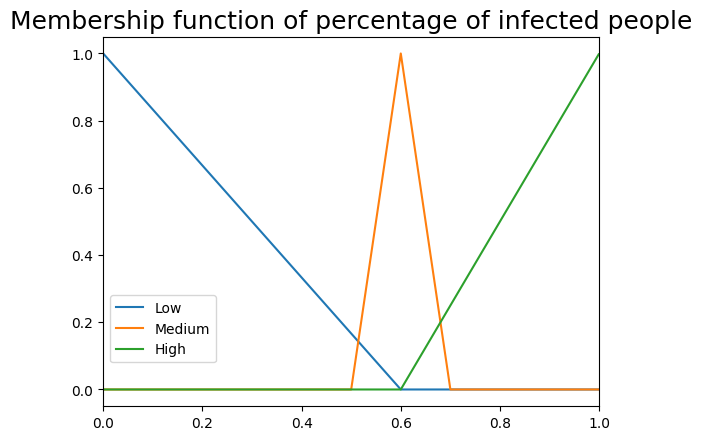

In [3]:
# 感染人数百分比隶属度函数
x = np.arange(0, 1, 0.001)
infection = []
for i in x:
    infection.append(FuzzyLogic.calculate_infection_percentage_membership(i))
infection = np.array(infection)
plt.title('Membership function of percentage of infected people', fontsize=18)
plt.plot(x, infection[:, 0])
plt.plot(x, infection[:, 1])
plt.plot(x, infection[:, 2])
plt.xlim(0, 1)
plt.legend(['Low', 'Medium', 'High'], loc='lower left', bbox_to_anchor=(0, 0.1))

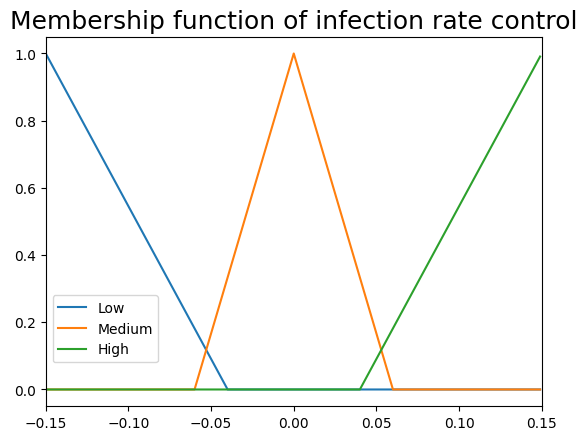

In [4]:
# 感染率控制隶属度函数
x = np.arange(-0.15, 0.15, 0.001)
infection = []
for i in x:
    infection.append(FuzzyLogic.calculate_infection_rate_control_membership(i))
infection = np.array(infection)
plt.title('Membership function of infection rate control', fontsize=18)
plt.plot(x, infection[:, 0])
plt.plot(x, infection[:, 1])
plt.plot(x, infection[:, 2])
plt.xlim(-0.15, 0.15)
plt.legend(['Low', 'Medium', 'High'], loc='lower left', bbox_to_anchor=(0, 0.1))

In [5]:
class Plague(object):
    def __init__(self):
        """
        分别初始化'感染人数百分比', '感染率', '有效感染率', '感染率控制'曲线
        """
        self.infected_percentage_curve = [0.]
        self.infection_rate_curve = [0.]
        self.effective_infection_rate_curve = [0.]
        self.infection_rate_control_curve = [0.]

    def recovery_rate(self):
        """
        获取康复率
        :return: float, 康复率
        """
        tmp = self.infected_percentage_curve[-1]
        return .5 * tmp * tmp

    def spread_plague(self, infection_rate_control):
        """
        传播瘟疫

        :param infection_rate_control: float, 感染率控制
        """

        curr_infection_rate = self.infection_rate_curve[-1]
        # 感染率 = 之前感染率 + 感染率控制，控制感染率不能太高，防止当地政府过度关注
        infection_rate = max(0., min(.5, curr_infection_rate + infection_rate_control))
        # 有效感染率 = 感染率 - 康复率
        effective_infection_rate = infection_rate - self.recovery_rate()

        # 更新感染人数百分比
        infection_percentage = max(0., min(1., self.infected_percentage_curve[-1] + effective_infection_rate * .1))

        # 更新状态曲线
        self.infected_percentage_curve.append(infection_percentage)
        self.infection_rate_curve.append(infection_rate)
        self.effective_infection_rate_curve.append(effective_infection_rate)
        self.infection_rate_control_curve.append(infection_rate_control)

    def checkInfectionStatus(self):
        """
        查询当前感染的情况

        :returns:
        infected_percentage: float, 感染人数百分比
        """
        infected_percentage = self.infected_percentage_curve[-1]

        return infected_percentage

    def viewPlague(self, iteration, save_dir='', filename='plague', show_plot=True):
        """
        绘制'感染人数百分比', '感染率', '感染率控制'曲线
        :param iteration: int, 迭代次数
        :param save_dir: str, 图像保存路径
        :param filename: str, 图像名称
        :param show_plot: boolean, 是否在显示屏上显示图像
        """
        color_list = ['#ff0000', '#32CD32', '#0000ff', '#d2691e', '#ff00ff', '#000000', '#373788']
        style_list = ['-', '--']

        num_plots = 3

        plot_curve_args = [{'c': color_list[k],
                            'linestyle': style_list[0],
                            'linewidth': 3} for k in range(num_plots)]

        plot_vert_args = [{'c': color_list[k],
                           'linestyle': style_list[1],
                           'linewidth': 3} for k in range(num_plots)]

        font_size = 18

        fig, axes = plt.subplots(4, 1, figsize=(20, 22))

        day_x = [j * .1 for j in range(len(self.infected_percentage_curve))]
        x_ticks = day_x[::10]

        # 感染人数百分比
        ax = axes[0]
        ax.set_title('Infected percentage over days', loc='left', fontsize=font_size)
        ax.plot(day_x[:iteration + 1], self.infected_percentage_curve[:iteration + 1], **plot_curve_args[0])
        ax.plot(day_x[iteration:], self.infected_percentage_curve[iteration:], **plot_curve_args[1])
        ax.plot([day_x[iteration]] * 2, [0, self.infected_percentage_curve[iteration]], **plot_vert_args[2])

        ax.set_xlabel(xlabel='day', fontsize=font_size)
        ax.set_ylabel(ylabel='Infected percentage (%/day)', fontsize=font_size)
        ax.set_xticks(x_ticks)
        ax.xaxis.set_minor_locator(ticker.FixedLocator([day_x[iteration]]))
        ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.tick_params(which='minor', length=17, color='b', labelsize=13)
        ax.tick_params(labelsize=15)
        ax.set_ylim(0., 1.)
        ax.set_xlim(left=0)
        ax.grid(True, lw=1, ls='--', c='.75')

        # 感染率
        ax = axes[1]
        ax.set_title('Infection rate over days', loc='left', fontsize=font_size)
        ax.plot(day_x[:iteration + 1], self.infection_rate_curve[:iteration + 1],
                **plot_curve_args[0])
        ax.plot(day_x[iteration:], self.infection_rate_curve[iteration:],
                **plot_curve_args[1])
        ax.plot([day_x[iteration]] * 2, [0, self.infection_rate_curve[iteration]],
                **plot_vert_args[2])
        ax.set_xlabel(xlabel='day', fontsize=font_size)
        ax.set_ylabel(ylabel='Infection rate (%/day)', fontsize=font_size)
        ax.set_xticks(x_ticks)
        ax.xaxis.set_minor_locator(ticker.FixedLocator([day_x[iteration]]))
        ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.tick_params(which='minor', length=17, color='b', labelsize=13)
        ax.tick_params(labelsize=15)
        ax.set_ylim(0., 1.)
        ax.set_xlim(left=0)
        ax.grid(True, lw=1, ls='--', c='.75')

        # 有效感染率
        ax = axes[2]
        ax.set_title('Effective infection rate over days', loc='left', fontsize=font_size)
        ax.plot(day_x[:iteration + 1], self.effective_infection_rate_curve[:iteration + 1],
                **plot_curve_args[0])
        ax.plot(day_x[iteration:], self.effective_infection_rate_curve[iteration:],
                **plot_curve_args[1])
        y_min = ax.get_ylim()[0]
        ax.plot([day_x[iteration]] * 2,
                [y_min, self.effective_infection_rate_curve[iteration]],
                **plot_vert_args[2])

        ax.set_xlabel(xlabel='day', fontsize=font_size)
        ax.set_ylabel(ylabel='Effective infection rate (%/day)', fontsize=font_size)
        ax.set_xticks(x_ticks)
        ax.xaxis.set_minor_locator(ticker.FixedLocator([day_x[iteration]]))
        ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.tick_params(which='minor', length=17, color='b', labelsize=13)
        ax.tick_params(labelsize=15)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=y_min)
        ax.grid(True, lw=1, ls='--', c='.75')

        # 感染率控制
        ax = axes[3]
        ax.set_title('Infection rate control over days', loc='left', fontsize=font_size)
        ax.plot(day_x[:iteration + 1], self.infection_rate_control_curve[:iteration + 1],
                **plot_curve_args[0])
        ax.plot(day_x[iteration:], self.infection_rate_control_curve[iteration:],
                **plot_curve_args[1])
        y_min = ax.get_ylim()[0]
        ax.plot([day_x[iteration]] * 2,
                [y_min, self.infection_rate_control_curve[iteration]],
                **plot_vert_args[2])

        ax.set_xlabel(xlabel='day', fontsize=font_size)
        ax.set_ylabel(ylabel='Infection rate control (%/day)', fontsize=font_size)
        ax.set_xticks(x_ticks)
        ax.xaxis.set_minor_locator(ticker.FixedLocator([day_x[iteration]]))
        ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.tick_params(which='minor', length=17, color='b', labelsize=13)
        ax.tick_params(labelsize=15)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=y_min)
        ax.grid(True, lw=1, ls='--', c='.75')

        if show_plot:
            plt.show()

        fig.savefig(os.path.join(save_dir, filename + '.png'))

In [6]:
plague = Plague()
FuzzyLogic.R = FuzzyLogic.fuzzy_relation_matrix()
iteration = 240
for i in range(iteration):
    infected_percentage = plague.checkInfectionStatus()
    infection_rate_control = FuzzyLogic.fuzzy_control(infected_percentage)
    plague.spread_plague(infection_rate_control)

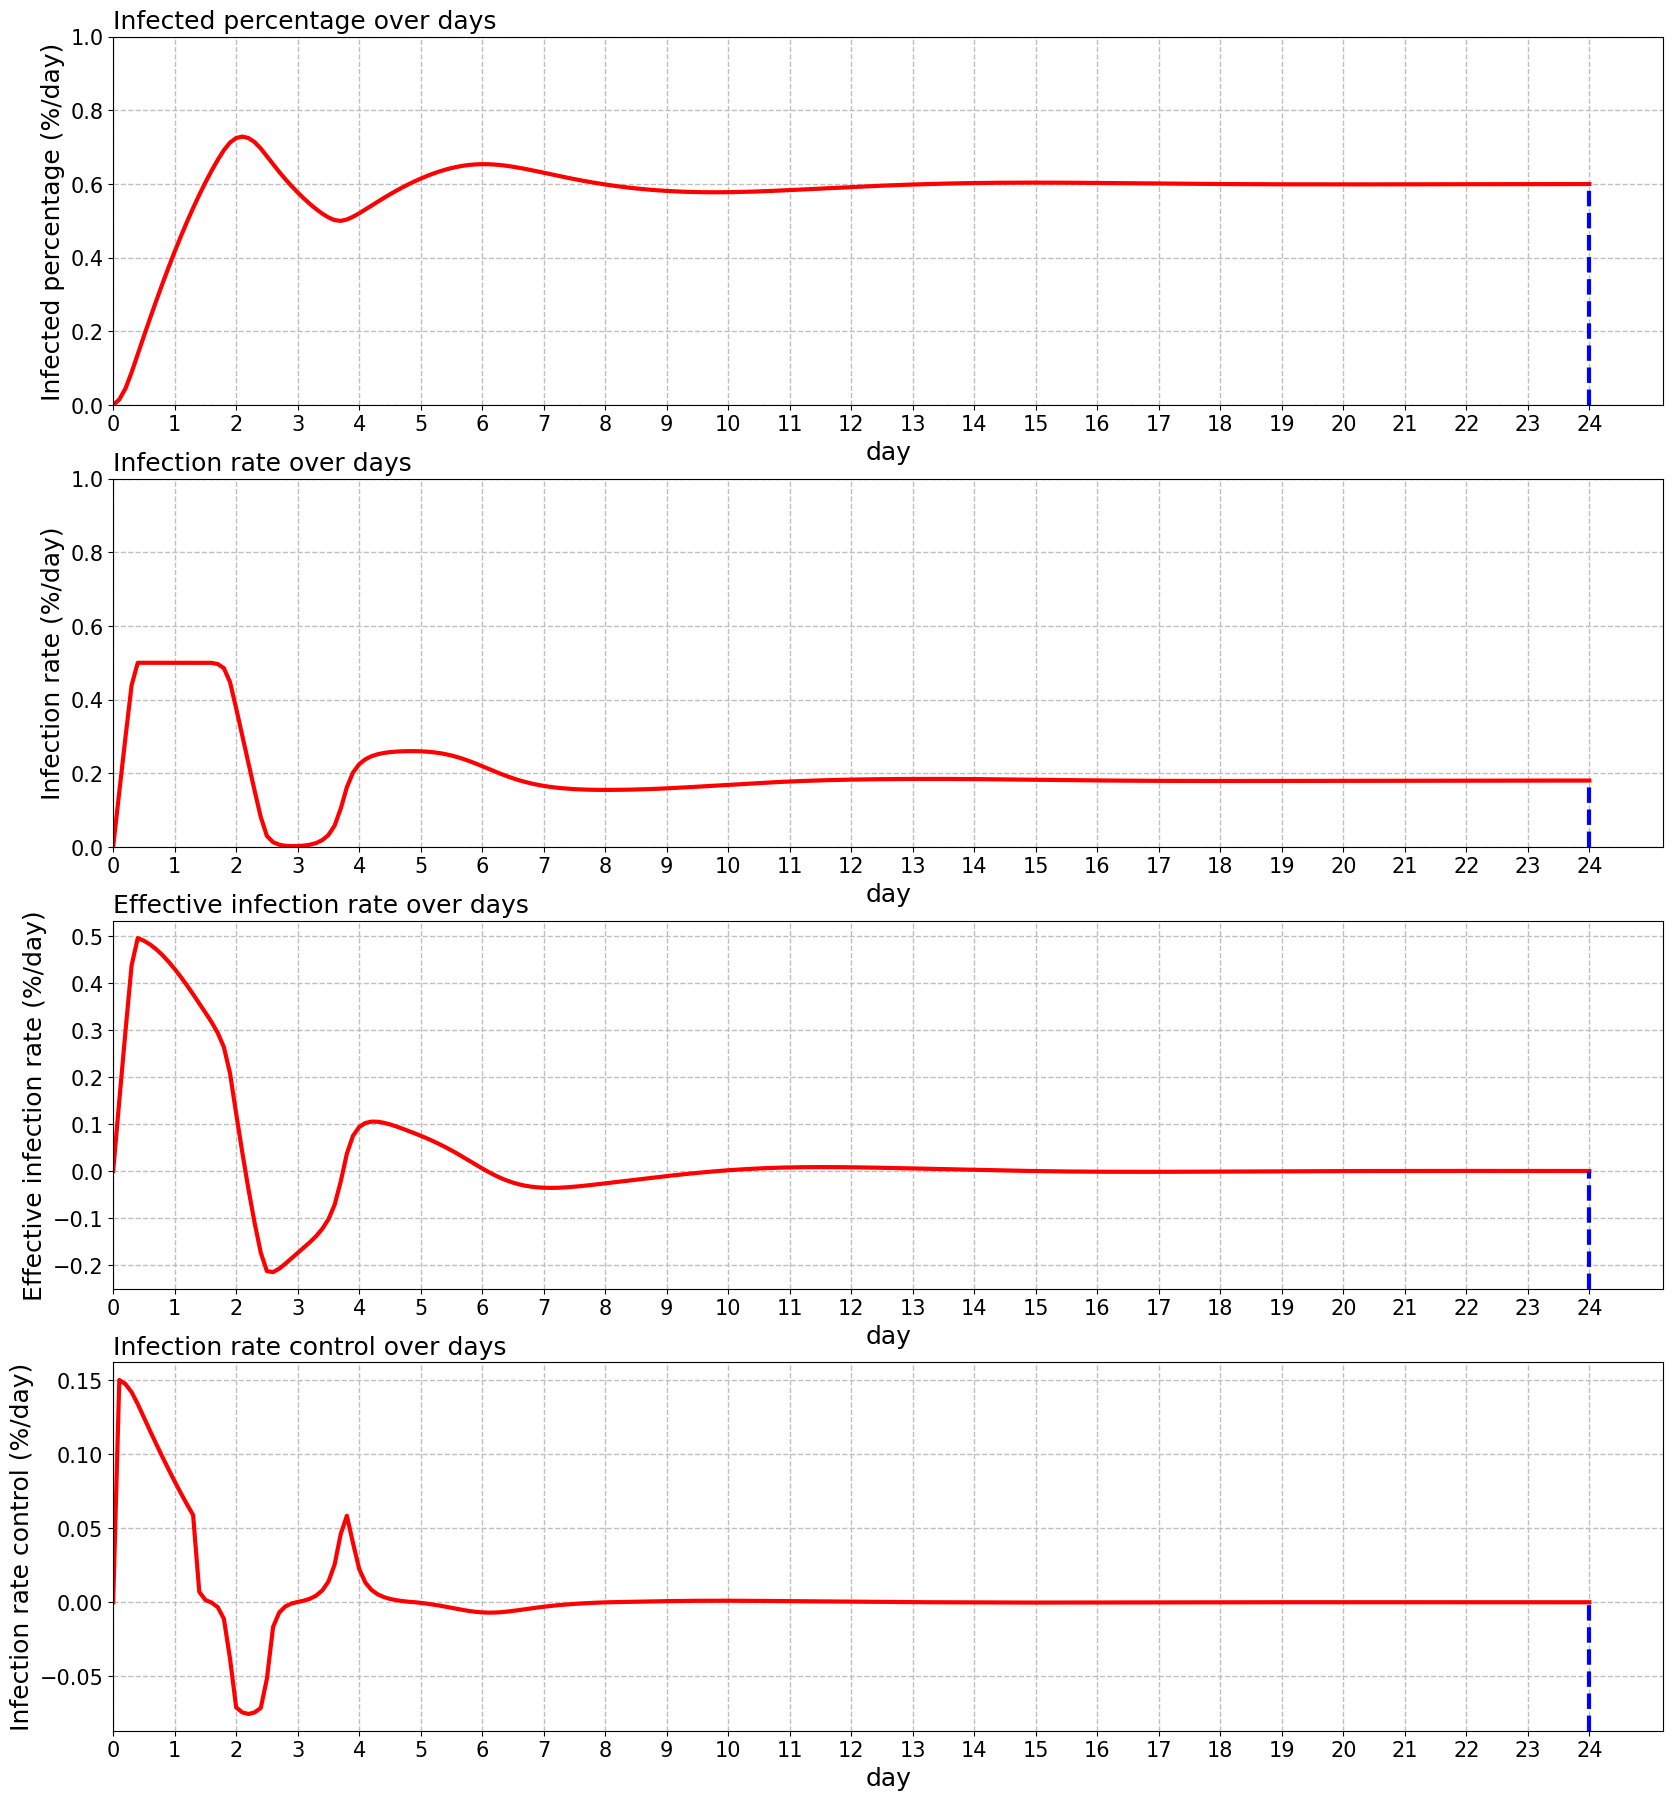

In [7]:
plague.viewPlague(iteration, save_dir='./', filename='plague', show_plot=True)